# Understand Basic Exclusions

### This exercise will introduce our basic land eligibility framework, a python package called GLAES. 
### You will understand how to prepare an exclusion calculator (ec) object and how to exclude features from it, specified with a "where" clause. You will also learn to extract information such as the remaining eligible area or how to save the results.

## Import required Python packages

In [1]:
# first glaes and geokit will be imported with common shortcuts gl and gk
import glaes as gl
import geokit as gk
# we also need some standard Python packages
import os
import pathlib

## Define folders and filepaths

### First get the basepath of the student_files folder on your system

In [2]:
# this is the current working directory
cwd = pathlib.Path().cwd()
print(cwd)

/storage_cluster/projects/2025_c-winkler_IMP-EGH/imp_egh_ice-2_v2024-25/student_files/exercises/Unit_04_LandEligibilityForVolatileRenewableEnergySources


In [3]:
# Now get the parent directory - this is the 'exercises' folder
exercises_folder = cwd.parent
print(exercises_folder)

/storage_cluster/projects/2025_c-winkler_IMP-EGH/imp_egh_ice-2_v2024-25/student_files/exercises


In [4]:
# And get the parent directory of that exercises folder again - this is now the 'student_files' folder
student_files_folder = exercises_folder.parent
print(student_files_folder)

/storage_cluster/projects/2025_c-winkler_IMP-EGH/imp_egh_ice-2_v2024-25/student_files


In [5]:
# based on that, we can now define our datafolder as a combination of that student_files parent folder and the "data" folder
data_basefolder = os.path.join(student_files_folder, 'data')
print(data_basefolder)

/storage_cluster/projects/2025_c-winkler_IMP-EGH/imp_egh_ice-2_v2024-25/student_files/data


### Define your local results folder

In [6]:
# NOTE: The results folder exists in your repo under /student_files/results/, but the files created therein will not be pushed back to git

# this is the current working directory ("student_files/exercises")
cwd = pathlib.Path().cwd()
print(f"Current working directory: {cwd}")

# the results folder is in "student_files/results", so go "2 folders up"
results_folder = os.path.join(os.path.dirname(os.path.dirname(cwd)), 'results')
# make sure folder exists
assert os.path.isdir(results_folder), f"results folder does not exist: '{results_folder}'"

print(f"Results folder:", results_folder)

Current working directory: /storage_cluster/projects/2025_c-winkler_IMP-EGH/imp_egh_ice-2_v2024-25/student_files/exercises/Unit_04_LandEligibilityForVolatileRenewableEnergySources
Results folder: /storage_cluster/projects/2025_c-winkler_IMP-EGH/imp_egh_ice-2_v2024-25/student_files/results


### Define filenames in the brefore-defined folders

In [7]:
# input path for our country file

# NOTE: The path begins at the level of the before-defined data folder so that both path elements can later be combined!

# capitalized COUNTRY stands for a variable here that will later be replaced
country_shp="region_shapefiles//COUNTRY_gadm_shapes_GID_level_1.shp"

In [8]:
# input folder for OSM data per country, always relative to the main exercise folder
osm_roads_basepath="exclusion_datasets//OSM//COUNTRY//COUNTRY_gis_osm_roads_free_1.shp"

## Define your input parameters

In [9]:
# define our study region
region='NER.4_1' # must be a GID_1 region

In [10]:
# the country is defined by the first 3 letters (ISO alpha 3 code) of the region code
country = region[:3]
country

'NER'

In [11]:
# set resolution to 100m x 100m
resolution=100

## Extract the study region

In [12]:
# NOTE that you can replace certain sub strings with a variable, like here our country name:
"abcdefCOUNTRYghijk".replace("COUNTRY", country)
# The spelling and capitals must match exactly. We use this below to adapt our basepath to the respective country

'abcdefNERghijk'

In [13]:
# from the global region shapefile, extract only the row for the selected region
region_df = gk.vector.extractFeatures(
    source=os.path.abspath(os.path.join(data_basefolder, country_shp.replace("COUNTRY", country))), 
    where=f"GID_1='{region}'",
    )
region_df

,geom,GID_0,NAME_0,GID_1,NAME_1,VARNAME_1,NL_NAME_1,TYPE_1,ENGTYPE_1,CC_1,HASC_1
0,"POLYGON ((7.16382504 13.04490757,7.15807676 13...",NER,Niger,NER.4_1,Maradi,None,None,Département,Department,None,NE.MA


In [14]:
# then define the region shape as the geometry object belonging to the region
region_shape = region_df['geom'].iloc[0]
# we now have a geometry object, an instance of osgeo.ogr.Geometry
region_shape

<osgeo.ogr.Geometry; proxy of <Swig Object of type 'OGRGeometryShadow *' at 0x7fda7b178450> >

AxHands(ax=<Axes: >, handles=[<matplotlib.patches.PathPatch object at 0x7fd80bac0370>], cbar=None)

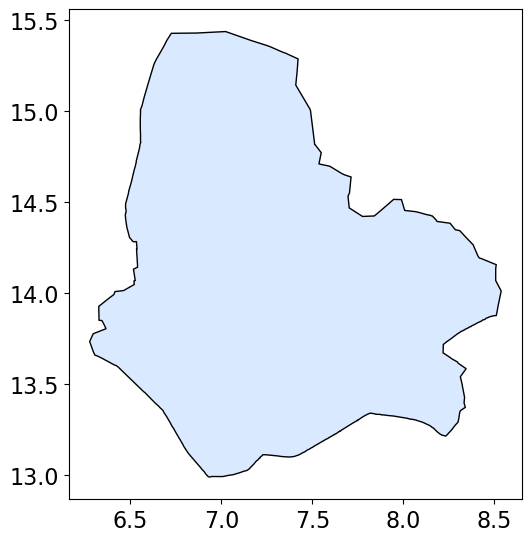

In [15]:
# we can also plot it
gk.drawGeoms(region_shape, figsize=(5,5))

## The Spatial/Coordinate Reference System

In [16]:
# All spatial reference systems (SRS) distort in some way, when the 3D world is projected into a 2D plane. Since we analyze AREAS here, we need an SRS that keeps true areas!
# NOTE that this is not the case for a latitude/longitude angular SRS: 1° longitude is more in kms in Niger than in Germany!

# we hence need an "equal area" reference system. Lambert Azimutal Equal Area (LAEA) reference systems are suitable here, some are predefined as standard "EPSG"
# the challenge with LAEA is that shapes will be distorted when too far away from the center, hence one needs to choose a suitable LAEA for each world region
# for example EPSG:3035 is a Europe-centered LAEA; and EPSG:3857 is centered on 0° latitude and 0° longitude (find more here: https://epsg.io/3857 )
# NOTE that you can also create customized LAEAs with a custom center, but for the scope of this exercise, 0°/0° center (EPSG:3857) should be sufficiently close to ECOWAS

print(gk.srs.EPSG3857)
# Note the "UNIT" in metre and the implicit center lat/lon in "EXTENSION"

PROJCS["WGS 84 / Pseudo-Mercator",
    GEOGCS["WGS 84",
        DATUM["WGS_1984",
            SPHEROID["WGS 84",6378137,298.257223563,
                AUTHORITY["EPSG","7030"]],
            AUTHORITY["EPSG","6326"]],
        PRIMEM["Greenwich",0,
            AUTHORITY["EPSG","8901"]],
        UNIT["degree",0.0174532925199433,
            AUTHORITY["EPSG","9122"]],
        AUTHORITY["EPSG","4326"]],
    PROJECTION["Mercator_1SP"],
    PARAMETER["central_meridian",0],
    PARAMETER["scale_factor",1],
    PARAMETER["false_easting",0],
    PARAMETER["false_northing",0],
    UNIT["metre",1,
        AUTHORITY["EPSG","9001"]],
    AXIS["Easting",EAST],
    AXIS["Northing",NORTH],
    EXTENSION["PROJ4","+proj=merc +a=6378137 +b=6378137 +lat_ts=0 +lon_0=0 +x_0=0 +y_0=0 +k=1 +units=m +nadgrids=@null +wktext +no_defs"],
    AUTHORITY["EPSG","3857"]]


In [17]:
# remember, if you wish to see what input are requested for a class or method, you can use ? in Jupyter Notebook to show the docstring explanations
gl.ExclusionCalculator?

Init signature:
gl.ExclusionCalculator(
    region,
    start_raster=None,
    srs=3035,
    pixelRes=100,
    where=None,
    padExtent=0,
    initialValue=True,
    verbose=True,
    **kwargs,
)
Docstring:     
The ExclusionCalculator object makes land eligibility (LE) analyses easy
and quick. Once initialized to a particular region, the ExclusionCalculator
object can be used to incorporate any geospatial dataset (so long as it is
interpretable by GDAL) into the LE analysis.


Note:
-----
By default, ExclusionCalculator is always initialized at 100x100 meter
resolution in the EPSG3035 projection system. This is well-suited to LE
analyses in Europe, however if another region is being investigated or else
if another resolution or projection system is desired for any other reason,
this can be incorporated as well during the initialization stage.

If you need to find a new projection system for your analyses, the following
website is helpful: http://spatialreference.org/ref/epsg/


Initi

<Axes: >

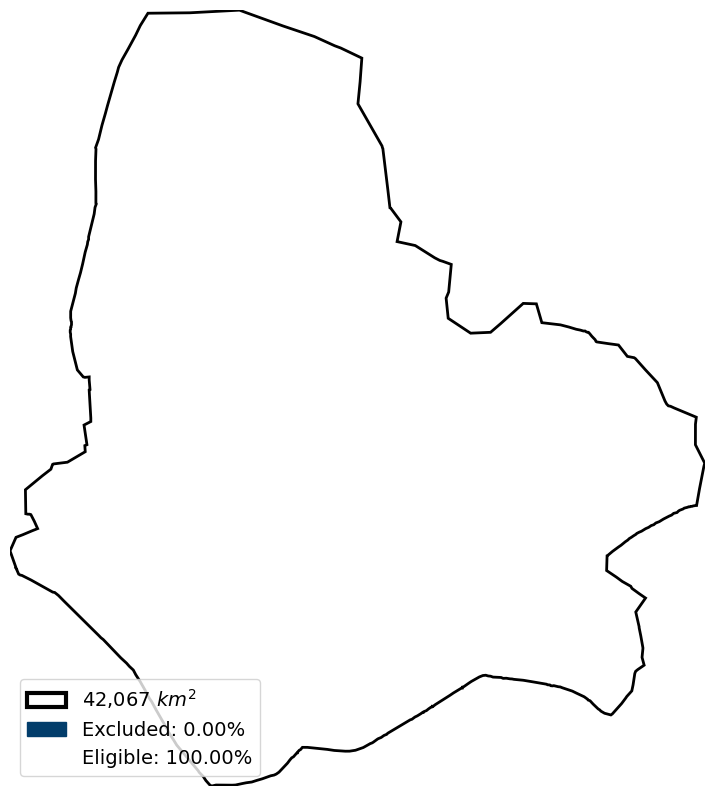

In [18]:
# now create an empty ExclusionCalculator class instance for our region, with the srs that we created above, and save as variable ec
ec = gl.ExclusionCalculator(
    region=region_shape,
    srs=gk.srs.EPSG3857,
    pixelRes=resolution,
)
# the .draw() method can be applied onto a glaes.ExclusionCalculator class instance and will draw the boundaries with the excluded area colored, with the area in km² and excluded/eligible percentage values
# currently no area is excluded since we just created an empty class instance
ec.draw()

In [19]:
# now we wish to exclude something from the region area
# let us therefore look at roads first
# generate the data path for the national roads shapefile 
exclusion_filepath=os.path.join(data_basefolder, osm_roads_basepath.replace('COUNTRY', country))
exclusion_filepath

'/storage_cluster/projects/2025_c-winkler_IMP-EGH/imp_egh_ice-2_v2024-25/student_files/data/exclusion_datasets//OSM//NER//NER_gis_osm_roads_free_1.shp'

<Axes: >

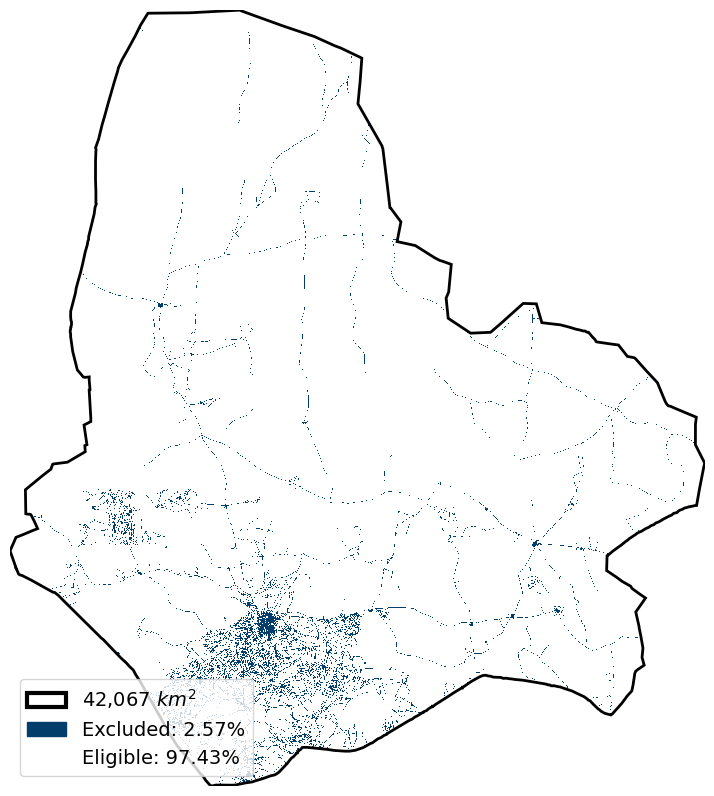

In [20]:
# so let us exclude all roads from our study region, we use the exclusion_filepath that we defined above
ec.excludeVectorType(
    source=exclusion_filepath, 
)
# show the results - a lot of lines but not much area excluded, huh?
ec.draw()

# NOTE: This method applies to vector type exclusions, like our line shapefile of roads as shown here
# A similar function is glaes.ExclusionCalculator.excludeRasterType() which is the equivalent for raster file exclusions

In [21]:
# As shown in the plot above, we only excluded a small percentage of our area (100% - remaining availability)
100 - ec.percentAvailable # exclusion in %

2.5726760908901554

In [22]:
# but the lines above contain exclusions for ALL roads in our region - this includes also small footpaths!
# for energy generation land eligibility, usually only larger roads need to be excluded
# so let us have a closer look at our exclusion data

# extract a dataframe with the exclusion data
# PS: the 'geom=region_shape' makes the process faster because only these geometry features = roads are extracted that touch our study region
roads_df=gk.vector.extractFeatures(exclusion_filepath, geom=region_shape)
# pandas.DataFrame.head() shows the first 5 rows of a dataframe to get an impression, but you can pass another integer to see more or less rows, here 15
roads_df.head(15)

,geom,osm_id,code,fclass,name,ref,oneway,maxspeed,layer,bridge,tunnel
0,"LINESTRING (7.1113201 13.4873089,7.1112838 13....",23583983,5112,trunk,Avenue Seyni Kountche,N9,F,30,0,F,F
1,"LINESTRING (7.1056615 13.5147391,7.1056706 13....",23791052,5112,trunk,Trans-Sahelian Highway,N 9,F,0,0,F,F
2,"LINESTRING (8.1631418 13.779819,8.1634851 13.7...",25501383,5121,unclassified,None,None,B,0,0,F,F
3,"LINESTRING (8.1147782 13.7103032,8.1151216 13....",25501429,5121,unclassified,None,None,B,0,0,F,F
4,"LINESTRING (7.5336094 13.8074049,7.5339657 13....",25502096,5114,secondary,None,None,B,0,0,F,F
5,"LINESTRING (7.5336094 13.8074049,7.5334883 13....",25502119,5114,secondary,None,N 19,B,0,0,F,F
6,"LINESTRING (7.6368016 13.8936087,7.6339316 13....",25502131,5114,secondary,None,None,B,0,0,F,F
7,"LINESTRING (7.7709865 13.9124044,7.7698365 13....",25502137,5114,secondary,None,None,B,0,0,F,F
8,"LINESTRING (7.0544887 13.5946281,7.0544887 13....",38689860,5114,secondary,None,N 30,B,0,0,F,F
9,"LINESTRING (6.9883776 13.832069,6.9878545 13.8...",38689874,5114,secondary,None,None,B,0,0,F,F


In [23]:
# obviously the column/attribute 'fclass' contains information on the type of road
# let us see what unique road types we have in our country
roads_df["fclass"].unique()

array(['trunk', 'unclassified', 'secondary', 'track', 'tertiary',
       'residential', 'primary', 'path', 'service', 'trunk_link',
       'primary_link', 'footway', 'pedestrian', 'tertiary_link'],
      dtype=object)

In [24]:
# too many roads which are not relevant for our exclusion
# so let us write an sql query that filters only the primary roads

# the 'where' argument in ec.excludeVectorType() takes a string in an sql-like format
# the format is "ATTRIBUTE_NAME in ('VALUE_1', 'VALUE_2', ...)"
where_str = "fclass in ('motorway','trunk','primary','secondary','trunk_link','primary_link')"

In [25]:
# so now let us repeat the process, but this time we exclude only relevant roads!

# BUT: first reset our ec object! (we still have the old exclusions in the variable in our computer memory)
# the function is the same as above, we simply create a new ec object with the same inputs as before
ec = gl.ExclusionCalculator(
    region=region_shape,
    srs=gk.srs.EPSG3857,
    pixelRes=resolution,
)
# Note: This must be done always when you want to calculate INDIVIDUAL exclusions. 
# If you wish to OVERLAP different exclusions, you should use the same ec object and apply different exclusions iteratively

# NOTE: By now, GLAES also contains advanced functions which can extract the individual exclusion in parallel to overlapping, iterative exclusions
# This is not part of this exercise, however - if interested, please check out glaes.ExclusionCalculator.percentAvailablePerCriterion at https://github.com/FZJ-IEK3-VSA/glaes (AFTER the exercises!)

# to show that the ec object is indeed "fresh" and empty, we check the available area percentage attribute:
# availability is 100% again, so our 2.66% exclusion from before is gone. You can also ec.draw() again, but it is slow!
ec.percentAvailable

100.0

<Axes: >

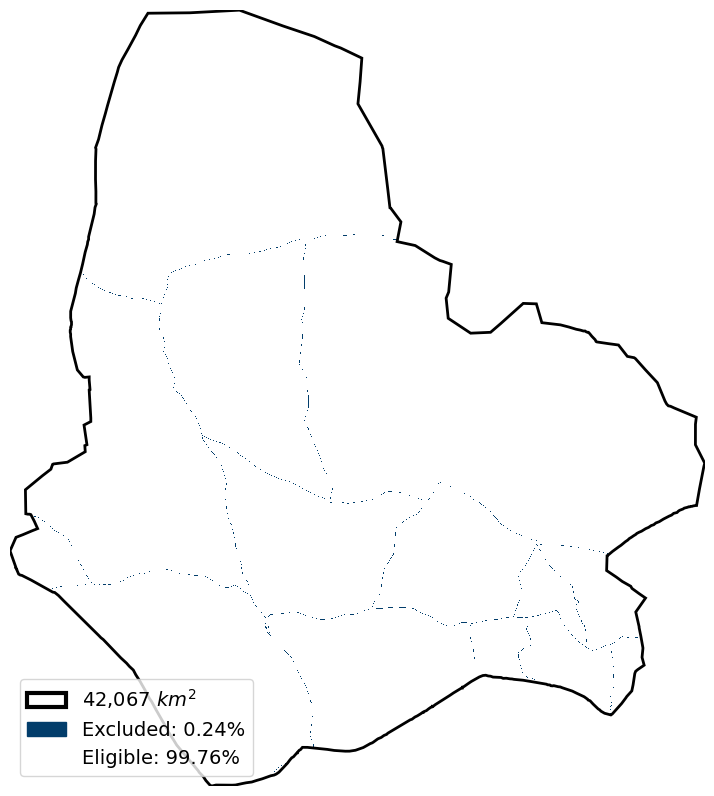

In [26]:
# now we apply a new exclusion to the clean ec object, only the main roads now, filtered by our sql-like query
# this query is added as a 'where' parameter
ec.excludeVectorType(
    source=exclusion_filepath, 
    where=where_str,
)
# we plot the results again to compare
# obviously way less roads now! Also our exclusion went down
ec.draw()

In [27]:
# in reality, we usually need to keep a minimum safety distance from roads
# let us guess wildly that for main roads this could be 200m in our country

# so let us exclude the main roads from our study region again, this time with 200m buffer!

# REMEMBER: first recreate our empty ec object again!
ec = gl.ExclusionCalculator(
    region=region_shape,
    srs=gk.srs.EPSG3857,
    pixelRes=resolution,
)

# check availability to be sure - must be 100% available (no exclusion yet)
ec.percentAvailable

100.0

In [28]:
# now we apply the new exclusion to the clean ec object, all roads again, this time with 200m exclusion buffer
# the buffer in meters can be added as 'buffer' parameter
# the where argument with our main roads filter is applied, too, of course
ec.excludeVectorType(
    source=exclusion_filepath, 
    where=where_str,
    buffer=200,
)

# you see that excluding features with a buffer takes a lot longer than without buffer

# how much did we exclude now?
100 - ec.percentAvailable # exclusion in %

Memory useage during calc: 411.6953125 MB


0.9957335214755005

<Axes: >

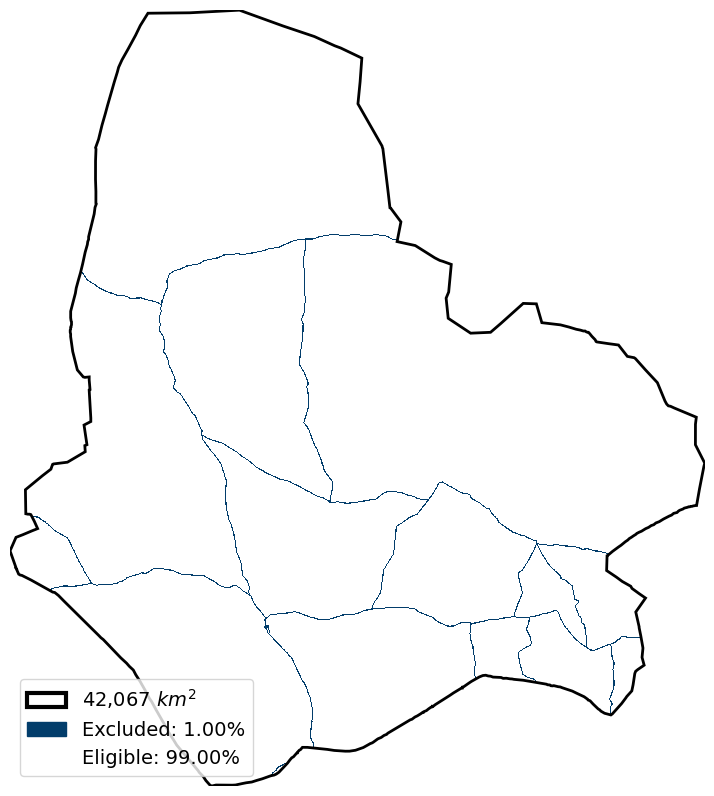

In [29]:
# let us have a look at the results again in a plot
ec.draw()
# the lines are 'thicker' now and the exclusion percentage is much higher
# but overall, main roads is not an important criterion in our study region!

In [30]:
# let us understand what else we can do with our results
# .areaAvailable attribute shows the remaining area after all exclusions
# since we have a small area exclusion only, you see that the area is slightly below the WHOLE region area (which you can see in the plot above):
ec.areaAvailable # this is the area in the unit of the LAEA, here meters -> area in m²

41648600000.0

In [31]:
# now let us save the results to disk
# the f"{VARIABLE}_some_basename.tif" string is very useful to define base name structures that can be adapted automatically
output_filename=f"{region}_exclusion_results_roadsTest.tif"
output_filename

'NER.4_1_exclusion_results_roadsTest.tif'

In [32]:
# the .save() method can be applied to the ec object and needs an 'output' argument with a .tif filepath where the file shall be saved
ec.save(output=os.path.join(results_folder, output_filename))

'/storage_cluster/projects/2025_c-winkler_IMP-EGH/imp_egh_ice-2_v2024-25/student_files/results/NER.4_1_exclusion_results_roadsTest.tif'

## TASK: Exclude ONLY the 'tertiary' roads and 'tertiary_links' from the study region and save the result to a NEW file!

In [33]:
# Add more cells to solve the task.

# NOTE: to add another cell in a Jupyter notebook quickly, you can exit the editing mode (when in a cell) by hitting ESC
# then hit 'a' (for above) or 'b' (for below) to add an empty cell below or above the current cell